<a href="https://colab.research.google.com/github/karsarobert/Deep-Learning-2023/blob/main/07/PTE_DL7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning gyakorlat


## 7. gyakorlat: konvolúciós hálózat
### 2023. október 18.

In [ ]:
!pip install -q jmd_imagescraper

from pathlib import Path
root = Path().cwd()/"images"

from jmd_imagescraper.core import *

duckduckgo_search(root, "Teddy", "teddy bears", max_results=100)
duckduckgo_search(root, "Black", "black bears", max_results=100)
duckduckgo_search(root, "Brown", "brown bears", max_results=100)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.5 MB/s eta 0:00:00
Duckduckgo search: teddy bears


Duckduckgo search: black bears


Duckduckgo search: brown bears


[PosixPath('/content/images/Brown/001_466eb94e.jpg'),
 PosixPath('/content/images/Brown/002_4140946b.jpg'),
 PosixPath('/content/images/Brown/003_75975557.jpg'),
 PosixPath('/content/images/Brown/004_690bc5b2.jpg'),
 PosixPath('/content/images/Brown/005_de75af39.jpg'),
 PosixPath('/content/images/Brown/006_4828f279.jpg'),
 PosixPath('/content/images/Brown/007_1e085144.jpg'),
 PosixPath('/content/images/Brown/008_7c0a0901.jpg'),
 PosixPath('/content/images/Brown/009_d2556aef.jpg'),
 PosixPath('/content/images/Brown/010_a0ad57c6.jpg'),
 PosixPath('/content/images/Brown/011_1d246c2d.jpg'),
 PosixPath('/content/images/Brown/012_95cdf6c3.jpg'),
 PosixPath('/content/images/Brown/013_52ee8492.jpg'),
 PosixPath('/content/images/Brown/014_7063f5e7.jpg'),
 PosixPath('/content/images/Brown/015_53d5f531.jpg'),
 PosixPath('/content/images/Brown/016_77d4a8d3.jpg'),
 PosixPath('/content/images/Brown/017_e16e6491.jpg'),
 PosixPath('/content/images/Brown/018_bdc24cb3.jpg'),
 PosixPath('/content/images/

# Ellenőrizzük a GPU-t

In [ ]:
!nvidia-smi

Wed Oct 18 15:21:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install split-folders

#Osszuk fel a fájlokat train és test készletre

In [ ]:
import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("images", output="bears",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=True)

Copying files: 300 files [00:00, 17975.85 files/s]


#Töltsük be a képeket ImageDataGenerator segítségével

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "bears/train/"
test_dir = "bears/val/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 240 images belonging to 3 classes.
Testing images:
Found 60 images belonging to 3 classes.


#class_names listába töltsük be az osztályok neveit

In [ ]:
import pathlib
import numpy as np
data_dir = pathlib.Path("bears/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Create a list of class_nmaes from the subdirectories
print(class_names)

['Black' 'Brown' 'Teddy']


#töltsük le a efficientnetb0 feature vektor modellt

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
efficient = hub.KerasLayer(efficientnet_url,
                                           trainable=False,
                                           name='feature_extractor',
                                           input_shape=IMAGE_SHAPE+(3,))

In [ ]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

#állítsuk össze a modellt

In [ ]:
model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(3, activation='softmax', name='output_layer') # create our own output layer
  ])

NameError: ignored

In [ ]:
model.summary()

In [ ]:
for layer_number, layer in enumerate(model.layers):
  print(layer_number, layer.name, layer.trainable)

0 feature_extraction_layer False
1 output_layer True


#model.compile, fit

In [ ]:
model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
history = model.fit(train_data, # only use 10% of training data
                                              epochs=10, # train for 5 epochs
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data))

NameError: ignored

#nézzük meg a modell eredményeit

In [ ]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

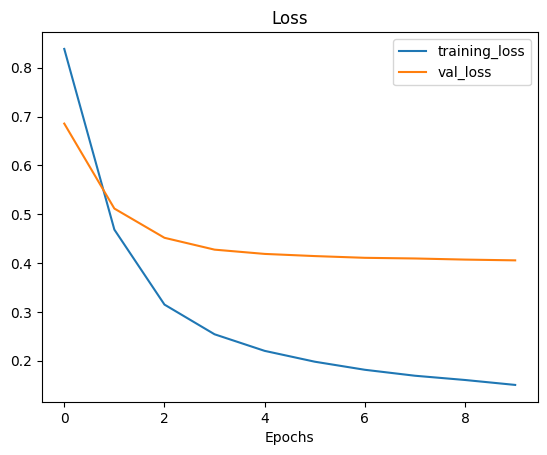

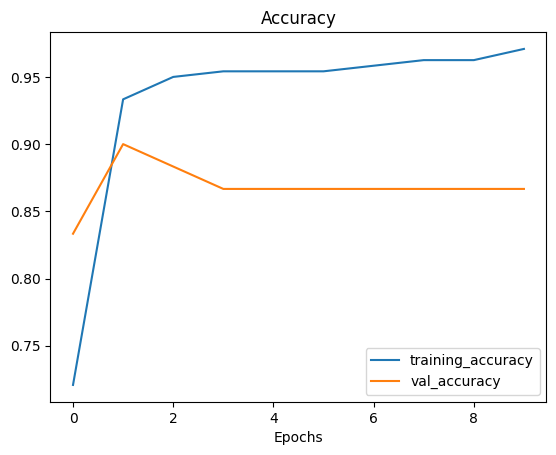

In [ ]:
plot_loss_curves(history)

In [ ]:
model.save('legjobbmodell')

In [ ]:
model2 = tf.keras.models.load_model("legjobbmodell")

In [ ]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)
    # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3) #tensor formatum
    # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])
  img = tf.expand_dims(img, axis=0)
  #img  = img[...,::-1]
  img -= [103, 116, 123]
  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [ ]:
image = load_and_prep_image("teddy.jpg")

In [ ]:
pred = model.predict(image)

1/1 [==============================] - 1s 901ms/step


In [ ]:
pred[0]

array([0.00517949, 0.05457989, 0.9402406 ], dtype=float32)

In [ ]:
np.argmax(pred[0])

2

In [ ]:
pred_class = class_names[np.argmax(pred[0])]
pred_class

'Teddy'

In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 12.1 M

In [ ]:
labels = class_names.tolist()

def imagenet_convert(img):
  img  = img.astype(float)#[...,::-1] # RGB --> BGR
  img -= [103.939, 116.779, 123.68]
  img = img/255.
  return img


def classify_image(inp):
  inp = imagenet_convert(inp)
  #inp = inp.reshape((-1, 224, 224, 3))
  inp = tf.expand_dims(inp, axis=0)
  prediction = model2.predict(inp).flatten()
  confidences = {labels[i]: float(prediction[i]) for i in range(3)}
  return {labels[i]: float(prediction[i]) for i in range(3)}



In [ ]:
import gradio as gr

gr.Interface(fn=classify_image,
             inputs=gr.Image(shape=(224, 224)),
             outputs=gr.Label(num_top_classes=3)).launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://2a49afbef4f0f31fd1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
